In [1]:
# Imports
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Define your path
path = "/Users/joche/Documents/GitHub/GVAR_modeling/"

# Data preperation

In [3]:
# Import all data for different variables
variable_list_raw = ['GDP', 'CPI','long_int','short_int','exch_rate','CPI_lag']
df_variable_raw = pd.read_excel(path + "Variable_data.xlsx",index_col=0, sheet_name=variable_list_raw)

# To prevent LinAlg errors:
df_variable_raw['exch_rate'].loc["United States"] += np.random.normal(0,0.01,df_variable_raw['exch_rate'].shape[1])

# Make a dictionary for all variables
df_variable = {}

# Transformating the data
df_variable['GDP'] = np.log(df_variable_raw['GDP'] / df_variable_raw['CPI'])
df_variable['inf_rate'] = np.log(df_variable_raw['CPI']) - np.log(df_variable_raw['CPI_lag'])
df_variable['long_int'] = 1/12 * np.log(1+ df_variable_raw['long_int'])
df_variable['short_int'] = 1/12 * np.log(1+ df_variable_raw['short_int'])
df_variable['exch_rate'] = np.log(df_variable_raw['exch_rate']) - np.log(df_variable_raw['CPI'])

In [4]:
# Example of the data of GDP
df_variable['GDP']

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP,,,,,,,,,,,,,,,,,,,,,
Australia,7.111526,7.109974,7.109045,7.108639,7.108802,7.109724,7.111451,7.113886,7.117012,7.120009,...,7.245003,7.242691,7.240865,7.237977,7.234116,7.229641,7.224830,7.220180,7.215890,7.212375
Brazil,7.298547,7.265720,7.255515,7.248464,7.248838,7.252285,7.254880,7.258204,7.255993,7.247954,...,6.245628,6.238087,6.235718,6.230620,6.238351,6.242242,6.244860,6.238253,6.232938,6.225192
Canada,7.182050,7.181960,7.179124,7.179272,7.178639,7.181598,7.184533,7.187242,7.188597,7.188877,...,7.249739,7.246856,7.236032,7.232001,7.232621,7.237186,7.237162,7.230052,7.228093,7.232778
France,7.380348,7.374446,7.367507,7.366746,7.365897,7.368816,7.372472,7.375927,7.374124,7.372342,...,7.389731,7.387556,7.382731,7.376268,7.373598,7.368834,7.374215,7.363898,7.361342,7.363840
Germany,7.682714,7.688150,7.695440,7.699543,7.700288,7.699928,7.699483,7.701185,7.704330,7.707481,...,7.624106,7.616684,7.606889,7.607831,7.605180,7.603438,7.586272,7.577714,7.571316,7.566637
Italy,7.396040,7.389030,7.383779,7.379578,7.376119,7.374964,7.376462,7.375475,7.373617,7.371353,...,7.043788,7.048628,7.044076,7.034828,7.031480,7.023761,7.020841,6.986684,6.981243,6.978765
Japan,12.850322,12.864937,12.870368,12.868049,12.867329,12.870474,12.871490,12.873739,12.872666,12.874797,...,12.959260,12.960084,12.961055,12.962100,12.956011,12.949845,12.943860,12.937610,12.938058,12.942606
Korea,13.774596,13.780142,13.781106,13.780902,13.780954,13.786446,13.787371,13.788933,13.793843,13.800024,...,14.099692,14.094856,14.090692,14.086429,14.082658,14.084086,14.080734,14.076859,14.075656,14.070829
New Zealand,5.010273,5.009471,5.010367,5.012259,5.014867,5.017504,5.019902,5.021249,5.021431,5.020249,...,5.200104,5.201987,5.205242,5.206727,5.206079,5.203146,5.198064,5.190857,5.181424,5.169673


In [52]:
# Define a list of all countries and variables (and a list of extended names for variables for plotting)
country_list = df_variable['GDP'].index.values
variable_list = np.array(['GDP', 'inf_rate','long_int','short_int','exch_rate'])
ext_variable_list = ['Real gross domestic product','Inflation rate','Long-term interest rate','Short-term interest rate','Real exchange rate']

# Define an empty dictionary
df = {}

# Loop over all countries and put their variable data in dictionary df
for country in country_list:
    country_collection = []
    
    for variable in variable_list:
        country_collection.append(df_variable[variable].loc[country])
    
    df[country] = pd.DataFrame(country_collection,index=variable_list)

In [53]:
# Example of the data of the United States
df['United States']

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP,9.442539,9.449189,9.451437,9.452844,9.454810,9.457333,9.458181,9.459295,9.459754,9.460273,...,9.439093,9.433012,9.422873,9.411266,9.414238,9.417735,9.418474,9.416719,9.418875,9.421459
inf_rate,0.005949,0.003243,0.005055,0.003914,0.001951,0.000557,0.001946,0.001943,0.003183,0.003173,...,0.013285,0.005597,0.010951,0.013633,-0.000147,-0.000368,0.002206,0.004032,-0.001025,-0.003081
long_int,0.010751,0.010992,0.011676,0.012210,0.012748,0.012210,0.011929,0.012239,0.011951,0.012225,...,0.008018,0.008026,0.008185,0.008652,0.009011,0.008637,0.008884,0.009168,0.008907,0.008981
short_int,0.004375,0.004185,0.004296,0.004351,0.004351,0.004430,0.004485,0.004383,0.004470,0.004391,...,0.000606,0.000755,0.001101,0.001544,0.002058,0.002269,0.002633,0.003148,0.003636,0.003676
exch_rate,-4.253483,-4.259146,-4.252206,-4.271507,-4.284246,-4.271209,-4.270005,-4.289595,-4.289193,-4.276587,...,-4.881345,-4.899852,-4.902196,-4.923633,-4.904186,-4.888845,-4.897310,-4.918819,-4.908425,-4.908345


# Trade matrix

In [55]:
# Import all trading data
df_trade_raw = pd.read_excel(path + "Trade_statistics.xlsx",index_col=[0,1])

# Get a list of all years (data from 1993 until 2022)
year_list = df_trade_raw.columns

# Define an empty dictionary
df_trade_year = {} 

# Loop over all years and put the trade weights data of that year in dictionary df_trade_year
for year in year_list:
    country_collection = []
    
    for country in country_list:
        country_collection.append(df_trade_raw.loc[country, year] / np.sum(df_trade_raw.loc[country, year]))
    
    df_trade_year[year] = pd.DataFrame(country_collection,index=country_list)

In [56]:
# Example of the trade weights on the year 2000
df_trade_year[1995]

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.009499,0.024256,0.015715,0.022248,0.031067,0.368421,0.139010,0.109102,0.021377,0.012284,0.063816,0.183204
Brazil,0.012822,0.000000,0.021274,0.065131,0.095000,0.080711,0.092992,0.021844,0.001296,0.011364,0.037926,0.056359,0.503281
Canada,0.003000,0.002689,0.000000,0.004871,0.007887,0.004335,0.022968,0.005707,0.000482,0.000620,0.001581,0.014831,0.931028
France,0.006890,0.014365,0.014387,0.000000,0.277243,0.155041,0.027482,0.013763,0.001199,0.006146,0.160982,0.169509,0.152993
Germany,0.011850,0.017602,0.015107,0.236602,0.000000,0.158056,0.046231,0.015814,0.001668,0.013074,0.093985,0.173398,0.216612
Italy,0.013134,0.016574,0.015812,0.224279,0.267343,0.000000,0.029327,0.012335,0.001646,0.006712,0.111315,0.121739,0.179782
Japan,0.034618,0.010164,0.030154,0.030228,0.080685,0.023379,0.000000,0.123875,0.005102,0.007577,0.013335,0.059860,0.581023
Korea,0.031966,0.021146,0.029763,0.021458,0.063209,0.023418,0.251006,0.000000,0.003509,0.006069,0.018803,0.065981,0.463673
New Zealand,0.302224,0.003885,0.022302,0.022475,0.034591,0.025347,0.205571,0.065756,0.000000,0.005530,0.008444,0.082456,0.221417
South Africa,0.042235,0.017777,0.019369,0.047268,0.167820,0.074288,0.119648,0.052628,0.002717,0.000000,0.043997,0.199527,0.212726


In [63]:
df_trade_year[2020]

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.006459,0.017251,0.015320,0.030662,0.004430,0.366359,0.185867,0.083081,0.009333,0.003785,0.121830,0.155624
Brazil,0.009109,0.000000,0.082324,0.039683,0.080517,0.059613,0.080692,0.074787,0.001579,0.019109,0.080068,0.049716,0.422803
Canada,0.004828,0.004831,0.000000,0.008398,0.014382,0.008350,0.027880,0.010460,0.000858,0.000707,0.003201,0.045327,0.870778
France,0.013292,0.014895,0.015101,0.000000,0.299694,0.157187,0.027530,0.023238,0.001797,0.006409,0.151322,0.131821,0.157714
Germany,0.019804,0.019679,0.021707,0.211370,0.000000,0.140988,0.041018,0.042136,0.002804,0.015251,0.087486,0.156236,0.241522
Italy,0.017397,0.017124,0.020088,0.212592,0.263540,0.000000,0.033456,0.022019,0.002573,0.007114,0.098167,0.106330,0.199601
Japan,0.053170,0.012898,0.031662,0.024715,0.076271,0.016495,0.000000,0.194559,0.008081,0.007296,0.009535,0.046870,0.518448
Korea,0.044333,0.028171,0.039030,0.021710,0.068409,0.023007,0.179184,0.000000,0.010453,0.004769,0.016443,0.032123,0.532370
New Zealand,0.336546,0.003430,0.032724,0.019454,0.038491,0.009416,0.145564,0.070463,0.000000,0.007428,0.005500,0.062468,0.268517
South Africa,0.027918,0.010812,0.011299,0.020661,0.259404,0.024212,0.139951,0.051943,0.002519,0.000000,0.033647,0.154920,0.262713


In [184]:
# Define the normal trade weight (which is an average of the last three years)
df_trade = (df_trade_year[2020] + df_trade_year[2021] + df_trade_year[2022])/3

# Potentially save this trade matrix
# df_trade.to_excel(path + "saved_values.xlsx")

# Show the chosen trade matrix
df_trade

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
Australia,0.000000,0.010022,0.014164,0.014274,0.026504,0.005641,0.441705,0.222185,0.073934,0.009536,0.005110,0.056375,0.120548
Brazil,0.008543,0.000000,0.071687,0.038948,0.075050,0.057034,0.078890,0.075848,0.001375,0.018676,0.090158,0.045526,0.438265
Canada,0.004615,0.005053,0.000000,0.007343,0.012802,0.005823,0.027182,0.011281,0.000883,0.000709,0.004001,0.034296,0.886010
France,0.012640,0.014547,0.014707,0.000000,0.294400,0.171517,0.025971,0.021429,0.002044,0.006511,0.155555,0.123540,0.157140
Germany,0.020259,0.021205,0.021493,0.208094,0.000000,0.149398,0.038248,0.039699,0.003107,0.016236,0.087555,0.140103,0.254603
Italy,0.017389,0.017485,0.020209,0.212202,0.264549,0.000000,0.030252,0.022228,0.002558,0.008034,0.103596,0.097037,0.204462
Japan,0.056912,0.014812,0.031543,0.024444,0.075202,0.018230,0.000000,0.196589,0.009996,0.008252,0.009478,0.042028,0.512513
Korea,0.063054,0.026059,0.038088,0.024480,0.059626,0.024464,0.164780,0.000000,0.012672,0.005267,0.015972,0.032019,0.533519
New Zealand,0.325075,0.003974,0.031449,0.018152,0.034132,0.010395,0.148405,0.082339,0.000000,0.007072,0.005665,0.057439,0.275902
South Africa,0.021761,0.010688,0.009855,0.018731,0.237414,0.029517,0.170230,0.053350,0.002074,0.000000,0.035472,0.157845,0.253063


# VARX model

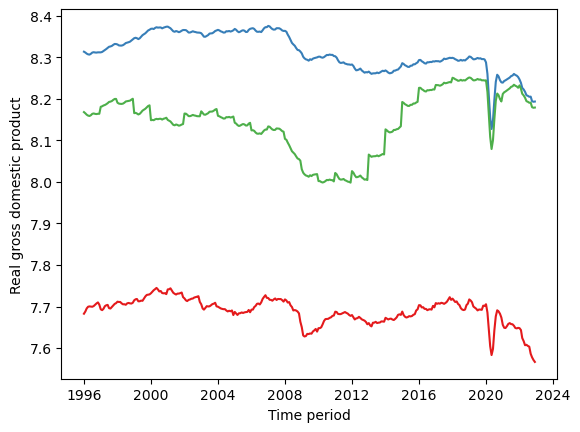

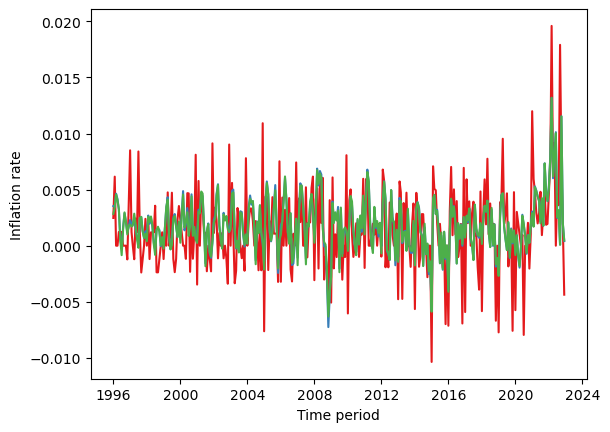

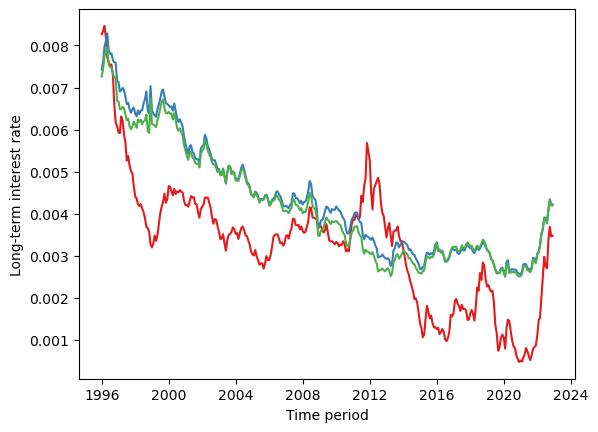

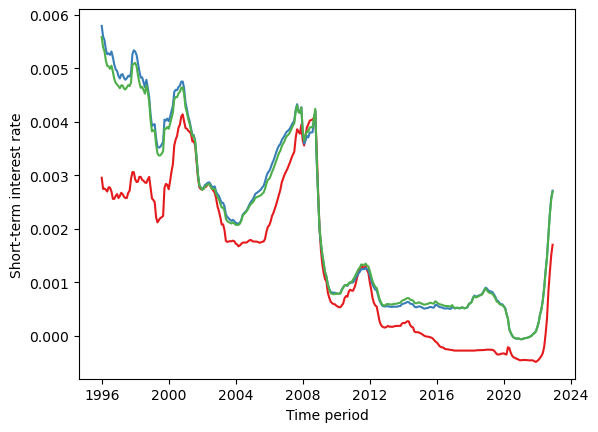

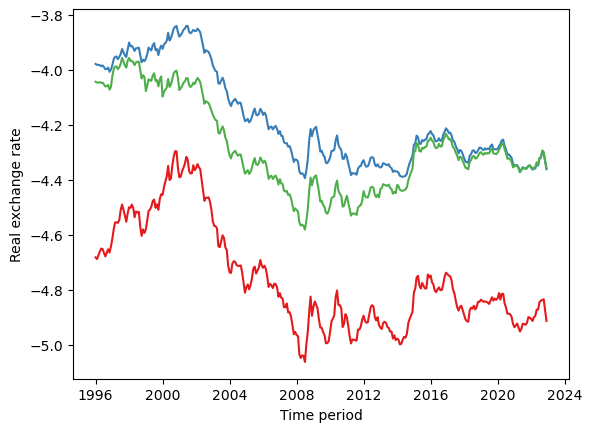

In [125]:
# Define a country
country = 'Germany'

sns.set_palette("Set1")

# Define the x_it and x_star for a country
x_it = df[country].T
x_star_fixed = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
x_star_vary = pd.concat([sum(df[foreign_country].T.loc[str(year)] * ((df_trade_year[year-1]+df_trade_year[year-2]+df_trade_year[year-3])/3).loc[country][foreign_country] for foreign_country in country_list) for year in year_list[3:]])

# Plot x_it and x_star for every variable
for i in range(len(variable_list)):
    sns.lineplot(x_it[variable_list[i]])
    sns.lineplot(x_star_fixed[variable_list[i]])
    sns.lineplot(x_star_vary[variable_list[i]])

    plt.xlabel("Time period")
    plt.ylabel(ext_variable_list[i])
    plt.show()

# Determine the lag order

In [185]:
def determine_lag(x_it,x_star,max_lag=8):
    
    # Define the current lowest BIC value
    min_bic = 0

    # Loop over all possible combinations
    for lag_x_it in range(1,max_lag+1):
        for lag_x_star in range(1,max_lag+1):
            
            # Initialize a dataframe with the x_star values of lag 0
            df_country = pd.concat([x_star])
            df_country.columns += "_L0"
    
            # Loop over all lag_x_it values to add the lagged values of x_it to df_country
            for lag in range(1,lag_x_it+1):
                lagged_x_it = x_it.shift(lag)
                lagged_x_it.columns += "_L"+str(lag) 
                df_country = pd.concat([df_country,lagged_x_it], axis=1)
            
            # Loop over all lag_x_star values to add the lagged values of x_star to df_country
            for lag in range(1,lag_x_star+1):
                lagged_x_star = x_star.shift(lag)
                lagged_x_star.columns += "_L"+str(lag) 
                df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
            # Create and fit the model
            model = VAR(endog = x_it.iloc[max_lag:], exog = df_country.iloc[max_lag:])
            results = model.fit(maxlags=0,trend='ct')
            
            # Determine the BIC value
            results_bic = -2 * results.llf / 5 + (2 + 5 * (lag_x_it+lag_x_star+1)) * np.log(324)
            
            # Update the lag and BIC value if the BIC value is smaller
            if (results_bic < min_bic):
                min_bic = results_bic
                best_lag_bic = (lag_x_it,lag_x_star)
    
    return best_lag_bic, min_bic

In [186]:
# Loop over all country to calculate the best lag order
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Run method to determine the lag order and its BIC value
    lag_results = determine_lag(x_it,x_star,max_lag=8)
    
    print("For",country)
    print("The lag order by BIC is",lag_results[0])
    print("The BIC value is",lag_results[1])
    print("")

For Australia
The lag order by BIC is (4, 1)
The BIC value is -3665.7260362358093

For Brazil
The lag order by BIC is (4, 4)
The BIC value is -2970.6743427097763

For Canada
The lag order by BIC is (4, 4)
The BIC value is -3459.9867880697702

For France
The lag order by BIC is (4, 4)
The BIC value is -3807.274742915697

For Germany
The lag order by BIC is (4, 4)
The BIC value is -3538.2938766217358

For Italy
The lag order by BIC is (4, 4)
The BIC value is -3725.1841388812218

For Japan
The lag order by BIC is (4, 1)
The BIC value is -3451.500303991029

For Korea
The lag order by BIC is (4, 1)
The BIC value is -3254.012312502878

For New Zealand
The lag order by BIC is (4, 4)
The BIC value is -3551.4085661287963

For South Africa
The lag order by BIC is (4, 4)
The BIC value is -3150.5080050317742

For Spain
The lag order by BIC is (4, 4)
The BIC value is -3737.9930397856506

For United Kingdom
The lag order by BIC is (4, 4)
The BIC value is -3260.8746650212265

For United States
The la

In [187]:
# Loop over all country to calculate the best lag order
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with varying trade weights
    x_star = pd.concat([sum(df[foreign_country].T.loc[str(year)] * ((df_trade_year[year-1]+df_trade_year[year-2]+df_trade_year[year-3])/3).loc[country][foreign_country] for foreign_country in country_list) for year in year_list[3:]])
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Run method to determine the lag order and its BIC value
    lag_results = determine_lag(x_it,x_star,max_lag=8)
    
    print("For",country)
    print("The lag order by BIC is",lag_results[0])
    print("The BIC value is",lag_results[1])
    print("")

For Australia
The lag order by BIC is (4, 1)
The BIC value is -3657.5170444096248

For Brazil
The lag order by BIC is (4, 1)
The BIC value is -2960.3232420650993

For Canada
The lag order by BIC is (4, 1)
The BIC value is -3408.1820984883866

For France
The lag order by BIC is (4, 1)
The BIC value is -3651.1689327300073

For Germany
The lag order by BIC is (4, 1)
The BIC value is -3478.9467077106137

For Italy
The lag order by BIC is (4, 1)
The BIC value is -3560.3839846084666

For Japan
The lag order by BIC is (4, 1)
The BIC value is -3434.7045106939795

For Korea
The lag order by BIC is (4, 1)
The BIC value is -3252.896481171364

For New Zealand
The lag order by BIC is (4, 1)
The BIC value is -3528.53383888165

For South Africa
The lag order by BIC is (4, 1)
The BIC value is -3054.57699430532

For Spain
The lag order by BIC is (4, 1)
The BIC value is -3530.199274027504

For United Kingdom
The lag order by BIC is (4, 1)
The BIC value is -3147.1266094307307

For United States
The lag o

# Test order of integration

In [188]:
# Define the DataFrames to fill the results in
adf_test_lag0 = pd.DataFrame(index=variable_list)
adf_test_lag1 = pd.DataFrame(index=variable_list)
adf_test_lag2 = pd.DataFrame(index=variable_list)

# Loop over every country and variable
for country in country_list:
    for variable in variable_list:
        
        # Take the data and its first and second difference
        non_dif = df[country].loc[variable]
        first_dif = np.diff(non_dif)
        second_dif = np.diff(first_dif)
        
        # Fill the DataFrames with the adf test statistics
        adf_test_lag0.loc[variable,country] = round(sm.tsa.stattools.adfuller(non_dif, autolag= 'AIC')[0],4)
        adf_test_lag1.loc[variable,country] = round(sm.tsa.stattools.adfuller(first_dif, autolag= 'AIC')[0],4)
        adf_test_lag2.loc[variable,country] = round(sm.tsa.stattools.adfuller(second_dif, autolag= 'AIC')[0],4)

In [147]:
# Show the results

adf_test_lag0
# adf_test_lag1
# adf_test_lag2

,Australia,Brazil,Canada,France,Germany,Italy,Japan,Korea,New Zealand,South Africa,Spain,United Kingdom,United States
GDP,-3.9972,0.1723,-3.1870,-2.0843,-0.7615,0.0668,-1.7600,-1.1241,-1.8749,0.9149,-1.0482,-0.1447,-1.8195
inf_rate,-2.3015,-8.8342,-3.4649,-2.0514,-0.9618,-0.7950,-2.6179,-3.8774,-3.6904,-4.5406,-3.2829,-1.3863,-3.9688
long_int,-2.1007,-2.0935,-1.8570,-1.8167,-3.5143,-3.0291,-1.9575,-1.6703,-2.8168,-2.3803,-1.9494,-1.5656,-2.2266
short_int,-2.1967,-1.9729,-2.3774,-1.8776,-1.9043,-2.5281,-1.9795,-2.3196,-1.6292,-2.4652,-2.9912,-1.6485,-2.5937
exch_rate,-1.0666,-1.5518,-1.3361,-1.3967,-1.3184,-1.3118,-2.2597,-1.5331,-0.9751,-2.5683,-1.1651,-2.2472,0.3053


# Checking weights

In [189]:
def fit_model(x_it,x_star,lag_x_it,lag_x_star):
    
    # Initialize a dataframe with the x_star values of lag 0
    df_country = pd.concat([x_star])
    df_country.columns += "_L0"
    
    # Loop over all lag_x_it values to add the lagged values of x_it to df_country
    for lag in range(1,lag_x_it+1):
        lagged_x_it = x_it.shift(lag)
        lagged_x_it.columns += "_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_it], axis=1)
                
    # Loop over all lag_x_star values to add the lagged values of x_star to df_country
    for lag in range(1,lag_x_star+1):
        lagged_x_star = x_star.shift(lag)
        lagged_x_star.columns += "_L"+str(lag) 
        df_country = pd.concat([df_country,lagged_x_star], axis=1)
    
    # Create and fit the model
    model = VAR(endog = x_it.iloc[max_lag:], exog = df_country.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct')
    
    return results

In [200]:
# Define the chosen lag
lag_x_it = 4
lag_x_star = 4
max_lag = max(lag_x_it,lag_x_star)

# Define a DataFrame for the R_squared
df_Rsquared_fixed = pd.DataFrame(index=variable_list)

# Loop over all countries
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Create and fit the model
    results = fit_model(x_it,x_star,lag_x_it,lag_x_star)

    # Calculate all R^2's of all variables
    for variable in variable_list:
        df_Rsquared_fixed.loc[variable,country] = skm.r2_score(results.fittedvalues[variable+"_x_it"]+results.resid[variable+"_x_it"],results.fittedvalues[variable+"_x_it"])

In [202]:
# Define the chosen lag
lag_x_it = 4
lag_x_star = 4
max_lag = max(lag_x_it,lag_x_star)

# Define a DataFrame for the R_squared
df_Rsquared_vary = pd.DataFrame(index=variable_list)

# Loop over all countries
for country in country_list:

    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = pd.concat([sum(df[foreign_country].T.loc[str(year)] * ((df_trade_year[year-1]+df_trade_year[year-2]+df_trade_year[year-3])/3).loc[country][foreign_country] for foreign_country in country_list) for year in year_list[3:]])
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Create and fit the model
    results = fit_model(x_it,x_star,lag_x_it,lag_x_star)
    
    # Calculate all R^2's of all variables
    for variable in variable_list:
        df_Rsquared_vary.loc[variable,country] = skm.r2_score(results.fittedvalues[variable+"_x_it"]+results.resid[variable+"_x_it"],results.fittedvalues[variable+"_x_it"])

In [203]:
# Full DataFrame of R^2's
# df_Rsquared_fixed

# Mean of R^2's
np.mean(df_Rsquared_fixed,axis=1) 

GDP          0.997875
inf_rate     0.626561
long_int     0.989805
short_int    0.993366
exch_rate    0.991648
dtype: float64

In [204]:
# Full DataFrame of R^2's
# df_Rsquared_vary

# Mean of R^2's
np.mean(df_Rsquared_vary,axis=1) 

GDP          0.997175
inf_rate     0.621404
long_int     0.989689
short_int    0.993382
exch_rate    0.991310
dtype: float64

# Fitting the model

In [171]:
# Define the chosen lag
lag_x_it = 4
lag_x_star = 4
max_lag = max(lag_x_it,lag_x_star)

# Define two dictionaries for the parameter estimates and residuals
df_estimates = {}
resid_dict = {}

# Loop over all countries
for country in country_list:
    
    # Define x_it
    x_it = df[country].T
    x_it.index.freq = 'MS'
    x_it.columns = x_it.columns + "_x_it"
    
    # Define x_star with fixed trade weights
    x_star = sum(df[foreign_country].T * df_trade.loc[country][foreign_country] for foreign_country in country_list)
    x_star.index.freq = 'MS'
    x_star.columns = x_star.columns + "_x_star"
    
    # Create and fit the model
    results = fit_model(x_it,x_star,lag_x_it,lag_x_star)

    # Fill the parameter estimates of the VARX model in the dictionary
    df_estimates[country] = results.params[x_it.columns.tolist()].T

    # Fill the residuals of the VARX model in the dictionary
    resid_dict[country] = results.resid

In [205]:
# Example of the VARX estimates of Australia
df_estimates['France']

,const,trend,GDP_x_star_L0,inf_rate_x_star_L0,long_int_x_star_L0,short_int_x_star_L0,exch_rate_x_star_L0,GDP_x_it_L1,inf_rate_x_it_L1,long_int_x_it_L1,...,GDP_x_star_L3,inf_rate_x_star_L3,long_int_x_star_L3,short_int_x_star_L3,exch_rate_x_star_L3,GDP_x_star_L4,inf_rate_x_star_L4,long_int_x_star_L4,short_int_x_star_L4,exch_rate_x_star_L4
GDP_x_it,0.135489,-4.405612e-06,1.410859,0.420502,1.540913,-0.062984,-0.007597,2.945892,2.364295,0.992115,...,-3.822323,-1.029382,0.288691,-5.597500,-0.000012,1.024560,0.036651,-0.994355,2.880337,0.035787
inf_rate_x_it,-0.136864,9.786887e-06,-0.142119,0.850835,-1.580021,-0.114278,0.007163,-0.062508,-0.471719,-0.986310,...,0.710057,0.165452,-0.136579,5.185531,-0.013033,-0.126630,-0.005484,0.715864,-2.757997,-0.045655
long_int_x_it,0.000778,-3.923412e-07,0.009120,0.012643,0.622278,0.230690,-0.000874,-0.005558,0.000082,1.070962,...,-0.007442,0.008504,-0.071672,-0.334356,0.001542,-0.001208,-0.003186,-0.014419,0.224548,-0.000454
short_int_x_it,0.001051,-3.607901e-08,0.000129,-0.001516,0.032519,0.885462,-0.000147,-0.003325,-0.001657,-0.042996,...,0.005159,0.003351,0.001770,-0.182816,0.000004,-0.002744,0.000656,-0.002925,0.131895,-0.000250
exch_rate_x_it,0.135430,1.114181e-05,0.609496,0.982871,-0.315561,3.941925,1.308478,-0.024748,0.314927,2.283862,...,-0.746675,-0.009064,-3.208726,-3.853900,-0.098770,-0.324312,0.121069,-0.176539,2.337468,0.084839


# Stacking the GVAR model

In [173]:
# Defining lengths k_i, k_star and k:
k_i = k_star = len(variable_list)
k = len(variable_list) * len(country_list)

# Stack all a_i0 parameters
matrix_col = []
for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"const"])
a_0 = pd.concat(matrix_col)

# Stack all a_i1 parameters
matrix_col = []

for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"trend"])
a_1 = pd.concat(matrix_col)

# Stack all residuals
epsilon_t = pd.concat(resid_dict.values(), axis=1).T

In [174]:
def create_G_j(j):
    
    # Define an empty collection of matrices
    matrix_col = []

    # Loop over all countries
    for country in country_list:
        
        # Create Omega_i
        i = np.where(country_list == country)[0][0]
        E_i = np.hstack((np.zeros((k_i, i * k_i)), np.eye(k_i), np.zeros((k_i, (13-i-1) * k_i))))
        W_i = np.hstack([foreign_trade * np.eye(k_star) for foreign_trade in df_trade.loc[country]])
        Omega_i = np.vstack((E_i,W_i))
        
        # Create A_ij, depending on j
        if (j == 0):
            selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L0")]
            
            lambda_i = df_estimates[country].loc[:,selected_cols]
            A_i = np.hstack((np.eye(k_i),-lambda_i))
        else:
            selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_it_L"+str(j))]
            phi_i = df_estimates[country].loc[:,selected_cols]
            
            selected_cols = [col for col in df_estimates[country].columns if col.endswith("x_star_L"+str(j))]
            lambda_i = df_estimates[country].loc[:,selected_cols]
            
            A_i = np.hstack((phi_i,lambda_i))
            
        # Finally, compute G_i by A_i and Omega_i
        G_i = A_i @ Omega_i
        matrix_col.append(G_i)
    
    # Return G_j
    return np.vstack(matrix_col)

In [179]:
# To show that this method works, we compute the residuals by matrices G:

# Create matrices G_j
G_0 = create_G_j(j=0)
G_1 = create_G_j(j=1)
G_2 = create_G_j(j=2)
G_3 = create_G_j(j=3)
G_4 = create_G_j(j=4)

# Function to get the x_t of time t and lag l
def x_t(l,t): 
    return pd.concat([df[country].T for country in country_list],axis=1).T.iloc[:,max_lag+t-l]

# Set time t between 0 and 319
t = 0

# The residuals of time t are the same as of the ones from the VARX* models
print(G_0 @ x_t(0,t) - a_0 - a_1 * (t+1) - G_1 @ x_t(1,t) -  G_2 @ x_t(2,t) - G_3 @ x_t(3,t) -  G_4 @ x_t(4,t))

GDP_x_it          0.000202
inf_rate_x_it    -0.000626
long_int_x_it     0.000062
short_int_x_it   -0.000024
exch_rate_x_it   -0.003547
                    ...   
GDP_x_it          0.001382
inf_rate_x_it    -0.002128
long_int_x_it     0.000098
short_int_x_it    0.000025
exch_rate_x_it    0.003220
Length: 65, dtype: float64


In [207]:
# Compare it with the residuals from the regression
epsilon_t

,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,1996-11-01,1996-12-01,1997-01-01,1997-02-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
GDP_x_it,0.000202,-0.000035,-0.000237,-0.000673,-0.000526,-0.000594,-0.001401,-0.000794,0.000564,0.000888,...,-0.000521,-0.001770,0.000568,0.000020,0.000471,-0.000331,-0.000469,0.000157,-0.000982,-0.000579
inf_rate_x_it,-0.000626,-0.000029,-0.000115,0.000152,-0.000221,-0.000184,0.000144,0.000446,-0.000124,0.000135,...,-0.000234,0.000619,-0.000064,0.000408,-0.000072,0.000150,0.000101,-0.000314,0.000190,0.000324
long_int_x_it,0.000062,0.000234,-0.000176,-0.000275,0.000078,-0.000192,-0.000103,0.000295,0.000107,0.000053,...,0.000052,0.000052,0.000194,0.000151,-0.000132,0.000139,0.000033,0.000150,0.000054,-0.000035
short_int_x_it,-0.000024,0.000039,0.000089,-0.000439,0.000253,-0.000097,0.000033,-0.000089,-0.000017,0.000194,...,-0.000082,-0.000043,0.000200,0.000269,0.000142,-0.000023,0.000189,-0.000023,0.000054,0.000003
exch_rate_x_it,-0.003547,-0.000590,0.015873,0.019451,-0.006967,0.006251,-0.014304,-0.013305,0.004879,-0.019000,...,-0.024889,-0.012945,0.019673,-0.026374,0.003056,-0.023980,-0.007022,-0.002124,-0.030813,0.004873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GDP_x_it,0.001382,0.000659,-0.000847,-0.000367,-0.001270,-0.001664,0.000193,0.001612,0.000995,-0.000445,...,0.000541,0.004595,-0.001647,-0.003493,0.001734,-0.002259,-0.002099,0.001594,0.001911,-0.001476
inf_rate_x_it,-0.002128,-0.001217,0.000573,0.000324,0.001283,0.001510,-0.000343,-0.001856,-0.000569,0.000769,...,-0.001161,-0.004775,0.001942,0.004168,-0.001453,0.002579,0.002657,-0.001553,-0.002122,0.001010
long_int_x_it,0.000098,-0.000667,-0.000210,0.000032,-0.000240,0.000288,0.000092,0.000022,-0.000117,-0.000591,...,0.000252,-0.000309,0.000140,0.000117,0.000215,-0.000189,-0.000012,-0.000201,-0.000107,0.000178
short_int_x_it,0.000025,-0.000047,0.000064,-0.000162,0.000153,-0.000009,0.000123,0.000084,0.000102,0.000026,...,0.000100,-0.000079,0.000043,0.000074,0.000063,0.000009,0.000069,0.000126,0.000231,-0.000199


In [206]:
# Calculate the inverse of G_0
G_0_inv = np.linalg.inv(create_G_j(j=0))

# Create a dictionary for the values of F_l
F_l_dict = {}

# Fill dictionary by computing the values of F_l 
for j in range(max_lag+1):
    F_l_dict[j] = G_0_inv @ create_G_j(j=j)

# GIRF

In [115]:
# Method to compute R_h for a given h
def calculate_R_h(h, memo={}):
    if h in memo:
        return memo[h]

    if h < 0:
        memo[h] = np.zeros((k,k))
    elif h == 0:
        memo[h] = np.eye(k)
    else:
        memo[h] = sum([create_F_l(l) @ calculate_R_h(h-l) for l in range(1,max_lag+1)])
    
    return memo[h]

In [247]:
def perform_GIRF(max_h,country_shock,variable_shock,country_choice,variable_choice):
    
    # Get the index of the country and variable of the shock and define e_j
    country_i = np.where(country_list == country_shock)[0][0]
    variable_i = np.where(variable_list == variable_shock)[0][0]
    e_j = np.zeros((k,1))
    e_j[country_i * 5 + variable_i] = -1
    
    # Compute Sigma
    Sigma = np.cov(epsilon_t)

    # Initialize an empty array for the index and names of the chosen countries and variables
    index_array = []
    name_array = []
    
    # Loop over all chosen countries and variables and append to arrays
    for variable in variable_choice:
        for country in country_choice:
            country_i = np.where(country_list == country)[0][0]
            variable_i = np.where(variable_list == variable)[0][0]
            index_array.append(country_i * 5 + variable_i)
            name_array.append(country[:3]+" "+variable)
    
    # Calculate the GIRF for every h
    girf_matrix = np.hstack([calculate_R_h(h) @ G_0_inv @ Sigma @ e_j / np.sqrt(e_j.T @ Sigma @ e_j) for h in range(0,max_h+1)])

    # Plot all GIRF in a plot
    for i in range(len(index_array)):
        sns.lineplot(x=np.arange(max_h+1),y=girf_matrix[index_array[i]], label=name_array[i])
    plt.plot()

# Choose shock:
Countries: ['Australia' 'Brazil' 'Canada' 'France' 'Germany' 'Italy' 'Japan' 'Korea'
 'New Zealand' 'South Africa' 'Spain' 'United Kingdom' 'United States']
 
Variable: ['GDP', 'inf_rate', 'long_int', 'short_int', 'exch_rate']

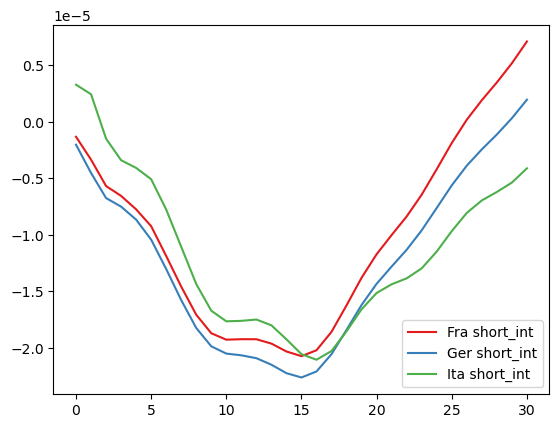

In [246]:
# Define the country and variable of the shock
country_shock = "New Zealand"
variable_shock = 'GDP'

# Define the countries and variables that should be in the IRF
country_choice = np.array(["France","Germany","Italy"])
variable_choice = np.array(["short_int"])

# Define the length of h
max_h = 30
perform_GIRF(max_h,country_shock,variable_shock,country_choice,variable_choice)